# ***Grupo 82 - Tech Challenge - Fase 2***

##1.Definição do Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base. Para isso utilize a base de dados contida no site da investing e selecione o período “diário”, com o intervalo de tempo que achar adequado. Você precisará demonstrar para o time de investimentos:
- O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
- Justificar a técnica utilizada;
- Atingir uma acuracidade adequada (acima de 70%).

Fonte de dados: https://br.investing.com/indices/bovespa-historical-data


## 2.Análise exploratória de dados

###Ajustando os dados

In [ ]:
#Se necessário, instalar tirando o # das linhas inferiores
#!pip install yfinance
#!pip install statsforecast
#!pip install --upgrade statsmodels
#!pip install pmdarima
#!pip install prophet
#!pip install sklearn

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import pmdarima as pm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import MeanSquaredError
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.metrics import MeanSquaredError

In [ ]:
df_ibov = yf.Ticker("^BVSP")

In [ ]:
ticker = "^BVSP"  # Substitua pelo ticker da ação desejada

# Definir o intervalo de datas desejado - format '%Y-%m-%d'"
start_date = '1900-01-01'
end_date = '2023-12-31'

# Obter os dados do Yahoo Finance para o ticker especificado no intervalo de datas
df_ibov = yf.download(ticker, start=start_date, end=end_date)

# Exibir as cotações de fechamento diárias
print(df_ibov['Close'])

[*********************100%%**********************]  1 of 1 completed
Date
1993-04-27        24.500000
1993-04-28        24.299999
1993-04-29        23.700001
1993-04-30        24.100000
1993-05-03        24.100000
                  ...      
2023-12-21    132182.000000
2023-12-22    132753.000000
2023-12-26    133533.000000
2023-12-27    134194.000000
2023-12-28    134185.000000
Name: Close, Length: 7593, dtype: float64


In [ ]:
df_ibov = df_ibov.reset_index('Date')
df_ibov['Date'] = pd.to_datetime(df_ibov['Date']) #realizando a conversão da data para formato datetime
df_ibov.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0
1,1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0
2,1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0
3,1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0
4,1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0


In [ ]:
df_ibov.shape #analisando linhas e colunas

(7593, 7)

In [ ]:
#Removendo colunas indesejadas
#df_ibov = df_ibov[["Date","Close","Open","High","Low","Volume"]]
df_ibov = df_ibov[["Date","Close"]]

#Alterando Nomenclatura das Colunas e ordenando a padronização conforme o site
#df_ibov.columns = ["ds", "Último", "Abertura", "Máxima", "Mínima", "Volume"]
df_ibov.columns = ["ds", "y"]

In [ ]:
df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      7593 non-null   datetime64[ns]
 1   y       7593 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.8 KB


In [ ]:
df_ibov.head()

,ds,y
0,1993-04-27,24.500000
1,1993-04-28,24.299999
2,1993-04-29,23.700001
3,1993-04-30,24.100000
4,1993-05-03,24.100000


In [ ]:
df_ibov.tail()

,ds,y
7588,2023-12-21,132182.0
7589,2023-12-22,132753.0
7590,2023-12-26,133533.0
7591,2023-12-27,134194.0
7592,2023-12-28,134185.0


In [ ]:
df_ibov.isnull().sum()

ds    0
y     0
dtype: int64

In [ ]:
#limpando dados nulos
df_ibov = df_ibov.dropna()

In [ ]:
df_ibov.shape

(7593, 2)

In [ ]:
df_ibov.describe().T

,count,mean,std,min,25%,50%,75%,max
y,7593.0,46806.580192,35631.129964,23.700001,12737.0,47926.0,66624.0,134194.0


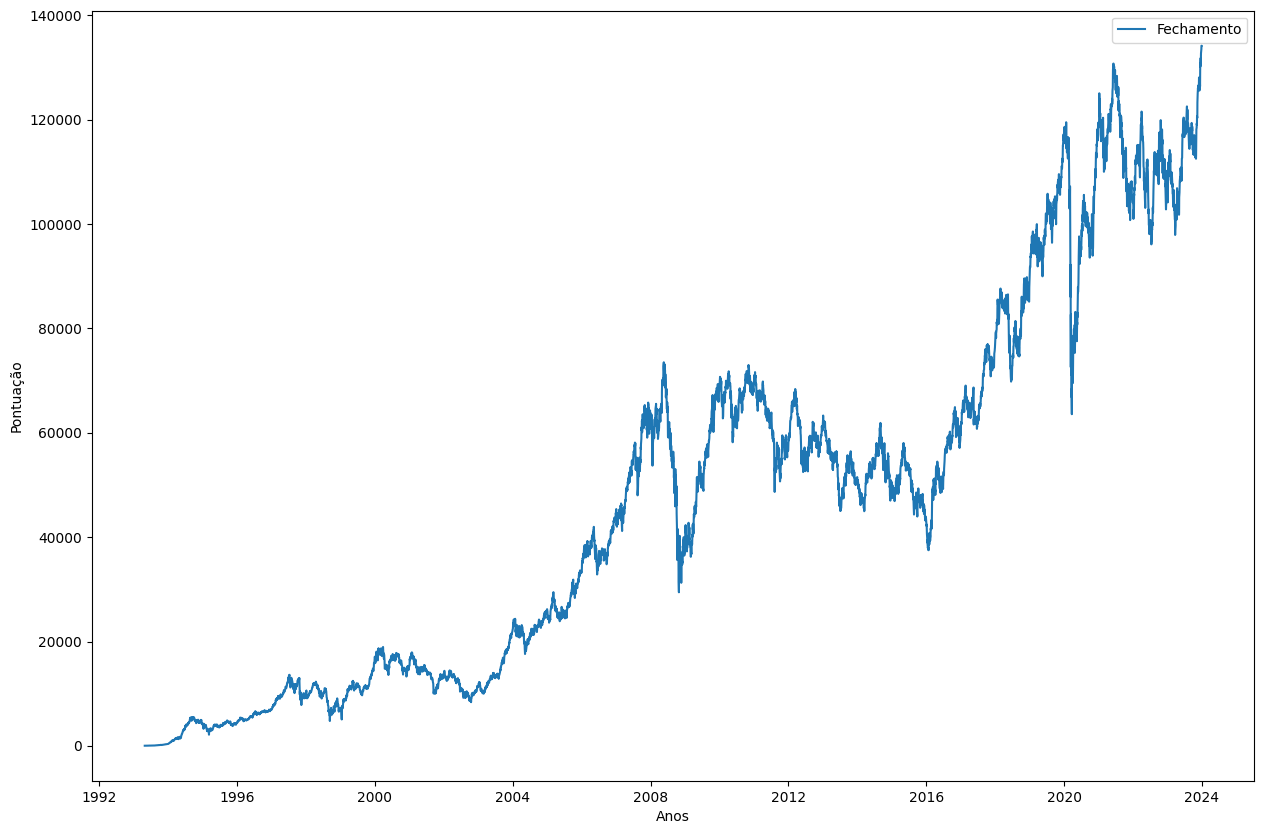

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_ibov['ds'], df_ibov['y'], label='Fechamento')
plt.xlabel('Anos')
plt.ylabel('Pontuação')
plt.legend(loc='best')
plt.show()

###Médias móveis

Por que usar médias móveis?

A análise de séries temporais, como os preços diários de fechamento da Ibovespa, pode ser desafiadora devido à volatilidade inerente desses dados. Flutuações diárias podem ser influenciadas por uma miríade de fatores, desde notícias econômicas globais até eventos políticos locais.

A **média móvel** é uma ferramenta estatística que suaviza essas flutuações, tornando mais fácil identificar tendências de longo prazo. Ao calcular a média de preços em uma janela de tempo específica que se move ao longo do tempo, obtemos uma linha suavizada que pode ajudar a:

1. **Identificar Tendências**: Uma média móvel ascendente sugere uma tendência de alta, enquanto uma descendente indica uma tendência de baixa.
2. **Reduzir o Ruído**: Ao suavizar flutuações de curto prazo, a média móvel ajuda a focar em movimentos de longo prazo.

In [ ]:
#Filtrando os dados
df_ibov = pd.DataFrame(df_ibov[['y','ds']])
df_ibov.set_index('ds', inplace=True)

In [ ]:
df_ibov['MM30'] = df_ibov['y'].rolling(30).mean().shift() #média móvel
df_ibov['MM180'] = df_ibov['y'].rolling(180).mean().shift() #média móvel

#Rolling para deslocamento. Este parâmetro especifica o número de observações usadas para calcular a estatística
#shift é utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo opcional

In [ ]:
df_ibov.head()

,y,MM30,MM180
ds,,,
1993-04-27,24.500000,NaN,NaN
1993-04-28,24.299999,NaN,NaN
1993-04-29,23.700001,NaN,NaN
1993-04-30,24.100000,NaN,NaN
1993-05-03,24.100000,NaN,NaN


In [ ]:
df_ibov.tail()

,y,MM30,MM180
ds,,,
2023-12-21,132182.0,126189.833333,116169.394444
2023-12-22,132753.0,126625.933333,116339.816667
2023-12-26,133533.0,127083.966667,116511.394444
2023-12-27,134194.0,127513.866667,116692.255556
2023-12-28,134185.0,127974.466667,116877.655556


In [ ]:
#pq o indice é importante
df_ibov.loc['2020-07-08']

y        99770.000000
MM30     93904.066667
MM180    98511.455556
Name: 2020-07-08 00:00:00, dtype: float64

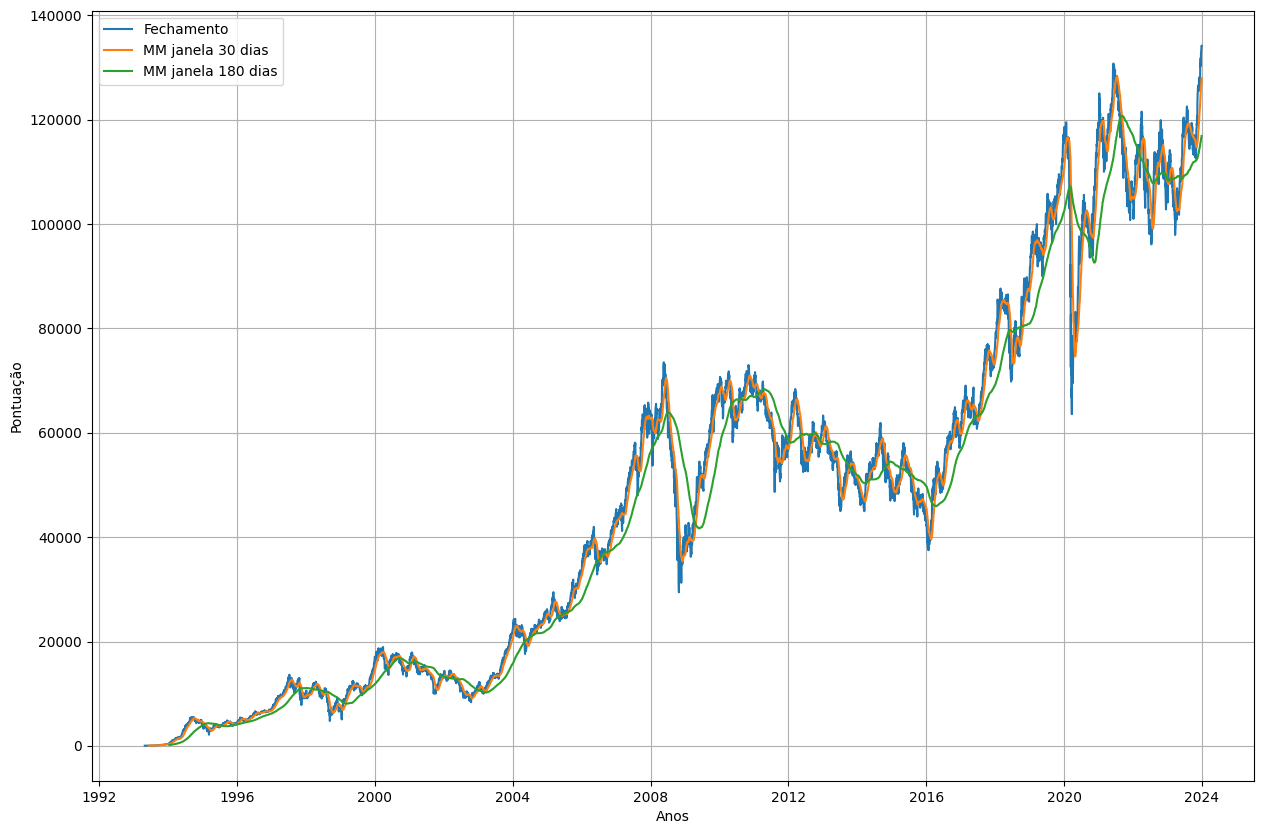

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_ibov['y'], label='Fechamento')
plt.plot(df_ibov['MM30'], label='MM janela 30 dias')
plt.plot(df_ibov['MM180'], label='MM janela 180 dias')
plt.xlabel('Anos')
plt.ylabel('Pontuação')
plt.legend(loc=2)
plt.show()

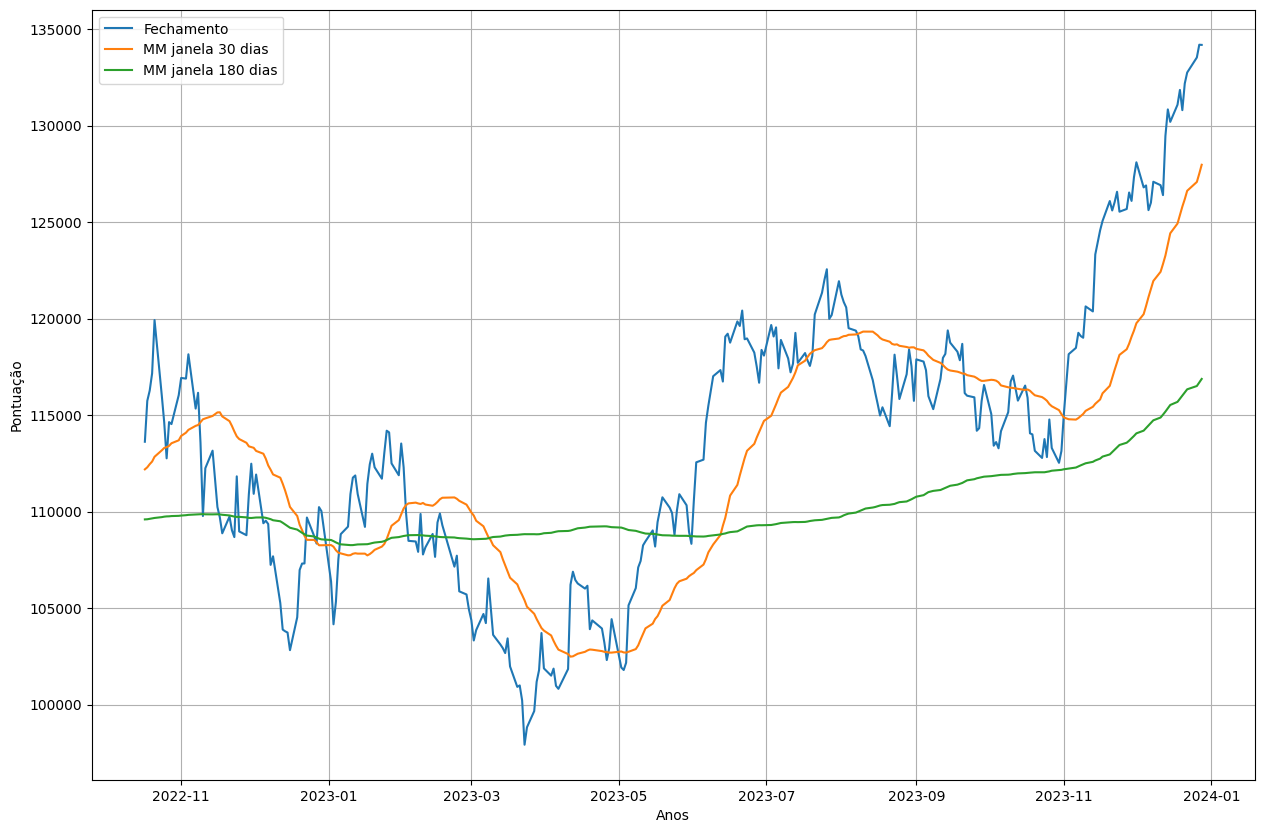

In [ ]:
limit = 300

plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df_ibov['y'][-limit:], label='Fechamento')
plt.plot(df_ibov['MM30'][-limit:], label='MM janela 30 dias')
plt.plot(df_ibov['MM180'][-limit:], label='MM janela 180 dias')
plt.xlabel('Anos')
plt.ylabel('Pontuação')
plt.legend(loc=2)
plt.show()

### Prevendo os "NAN" dias com base na média móvel aritmética

In [ ]:
df_ibov['MM30_forward_30'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [ ]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [ ]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df_ibov), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df_ibov):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MM = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df_ibov['y'].iloc[window_close], df_ibov['MM30_forward_30'].iloc[window_MM]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df_ibov.iat[index + i, df_ibov.columns.get_loc('MM30_forward_30')] = mean

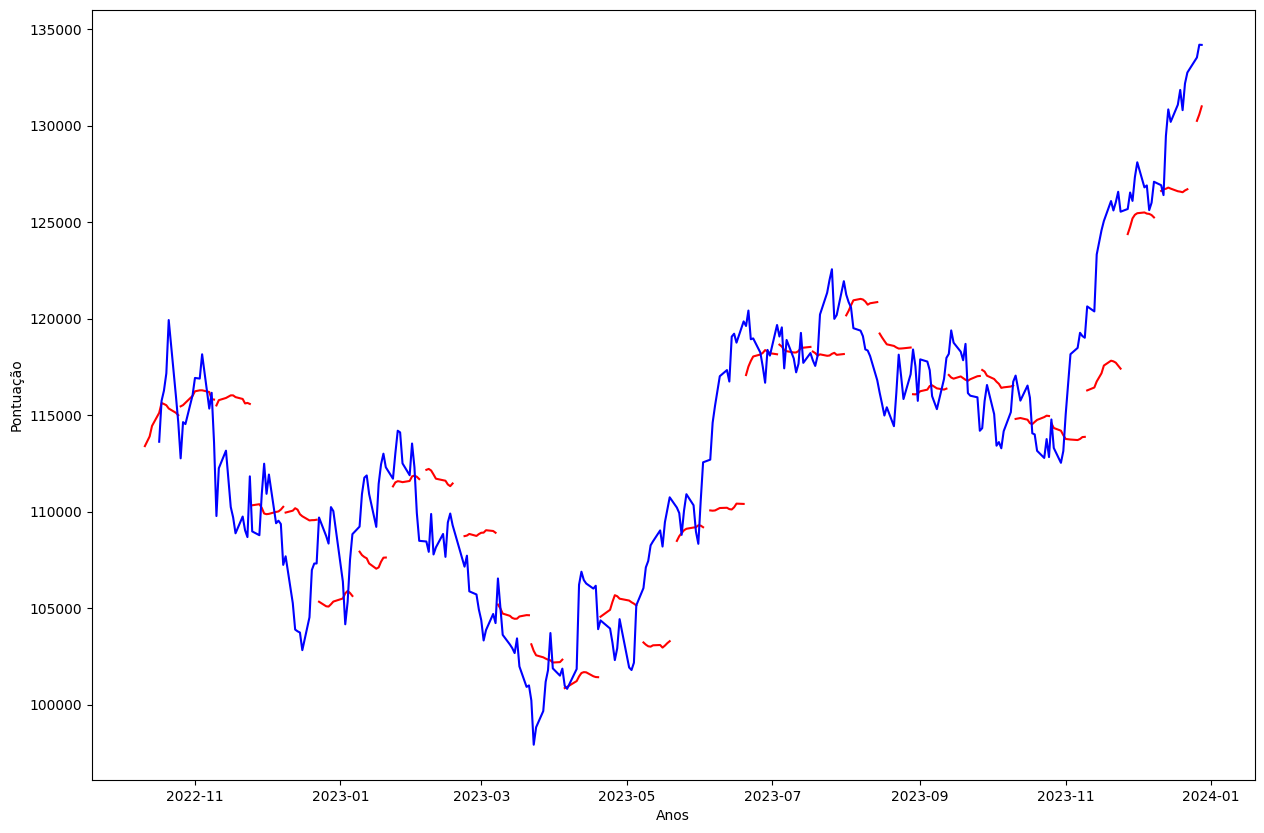

In [ ]:
plt.figure(figsize = (15, 10))

size = len(df_ibov)-limit - (len(df_ibov)-limit)%forward_days

for index in range(size, len(df_ibov), forward_days):
    plt.plot(df_ibov['MM30_forward_30'][index:index+forward_days], color='r')

plt.xlabel('Anos')
plt.ylabel('Pontuação')

plt.plot(df_ibov['y'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

Note que cada reta vermelha no gráfico representa uma previsão de 10 dias, baseado nos 10 dias anteriores. Por isso elas são descontínuas.


### Desvio padrão

A volatilidade é uma característica inerente aos mercados financeiros. O desvio padrão móvel é uma ferramenta que nos permite visualizar essa volatilidade ao longo do tempo. Ao calcular o desvio padrão dos preços em uma janela de tempo específica que se move ao longo do tempo, obtemos uma linha que indica a volatilidade:

**Identificar Volatilidade**: Um desvio padrão móvel crescente sugere aumento da volatilidade, enquanto um decrescente indica estabilização.

**Entender Riscos**: Períodos de alta volatilidade podem ser considerados mais arriscados.

**Tomada de Decisão**: Investidores podem usar a volatilidade para ajustar suas estratégias de investimento.

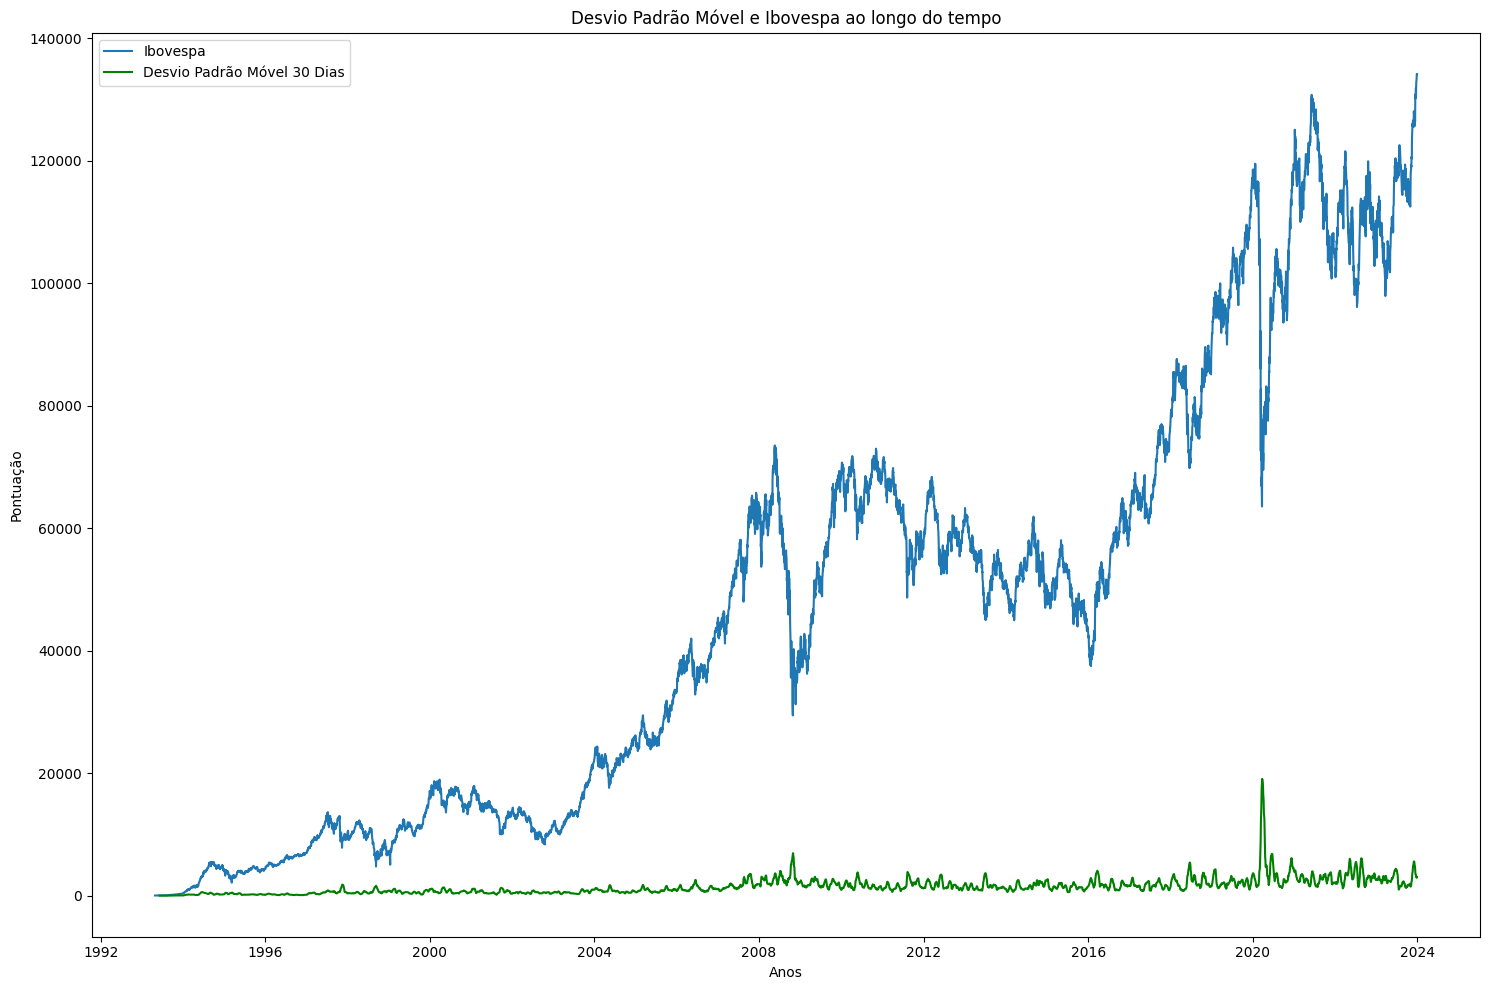

In [ ]:
# Calcular desvio padrão móvel
window = 30  # Janela de 30 dias
df_ibov['DesvioPadrao'] = df_ibov['y'].rolling(window=window).std()

# Plotar usando Seaborn
plt.figure(figsize=(15, 10))

sns.lineplot(data=df_ibov, x='ds', y='y', label='Ibovespa')
sns.lineplot(data=df_ibov, x='ds', y='DesvioPadrao', label='Desvio Padrão Móvel 30 Dias', color='green')

# Estilização do gráfico
plt.xlabel('Anos')
plt.ylabel('Pontuação')
#plt.xticks(df_ibov['ds'][::365], df_ibov['ds'][::365].dt.year, rotation=-45)
plt.title('Desvio Padrão Móvel e Ibovespa ao longo do tempo')

plt.legend()
plt.tight_layout()
plt.show()

---------------------------------------------------

As Bandas de Bollinger

são uma ferramenta de análise técnica popular e útil utilizada principalmente no mercado financeiro para analisar a volatilidade e os possíveis pontos de reversão em um preço de ativo. Criadas por John Bollinger na década de 1980, essas bandas são compostas por três linhas:

Média Móvel (Banda do Meio): É uma média móvel simples do preço do ativo ao longo de um determinado período. A média móvel pode ser calculada para diferentes períodos, mas o mais comum é utilizar 20 períodos.

Banda Superior: É uma linha que fica acima da média móvel e geralmente é configurada a uma distância de duas vezes o desvio padrão da média móvel durante o mesmo período utilizado para calcular a média.

Banda Inferior: É uma linha que fica abaixo da média móvel e está também configurada a uma distância de duas vezes o desvio padrão da média móvel.

As Bandas de Bollinger são úteis porque:

Indicam Volatilidade: Quando as bandas estão mais afastadas, isso indica maior volatilidade no preço do ativo. Quando as bandas estão mais próximas, indica menor volatilidade.

Possíveis Pontos de Reversão: Movimentos que ultrapassam as bandas superior ou inferior podem indicar condições de sobrecompra (se ultrapassar a banda superior) ou sobrevenda (se ultrapassar a banda inferior). Isso pode sugerir possíveis reversões no preço do ativo.

Tendências e Movimentos: As Bandas de Bollinger podem ajudar a identificar tendências e movimentos direcionais do preço do ativo.

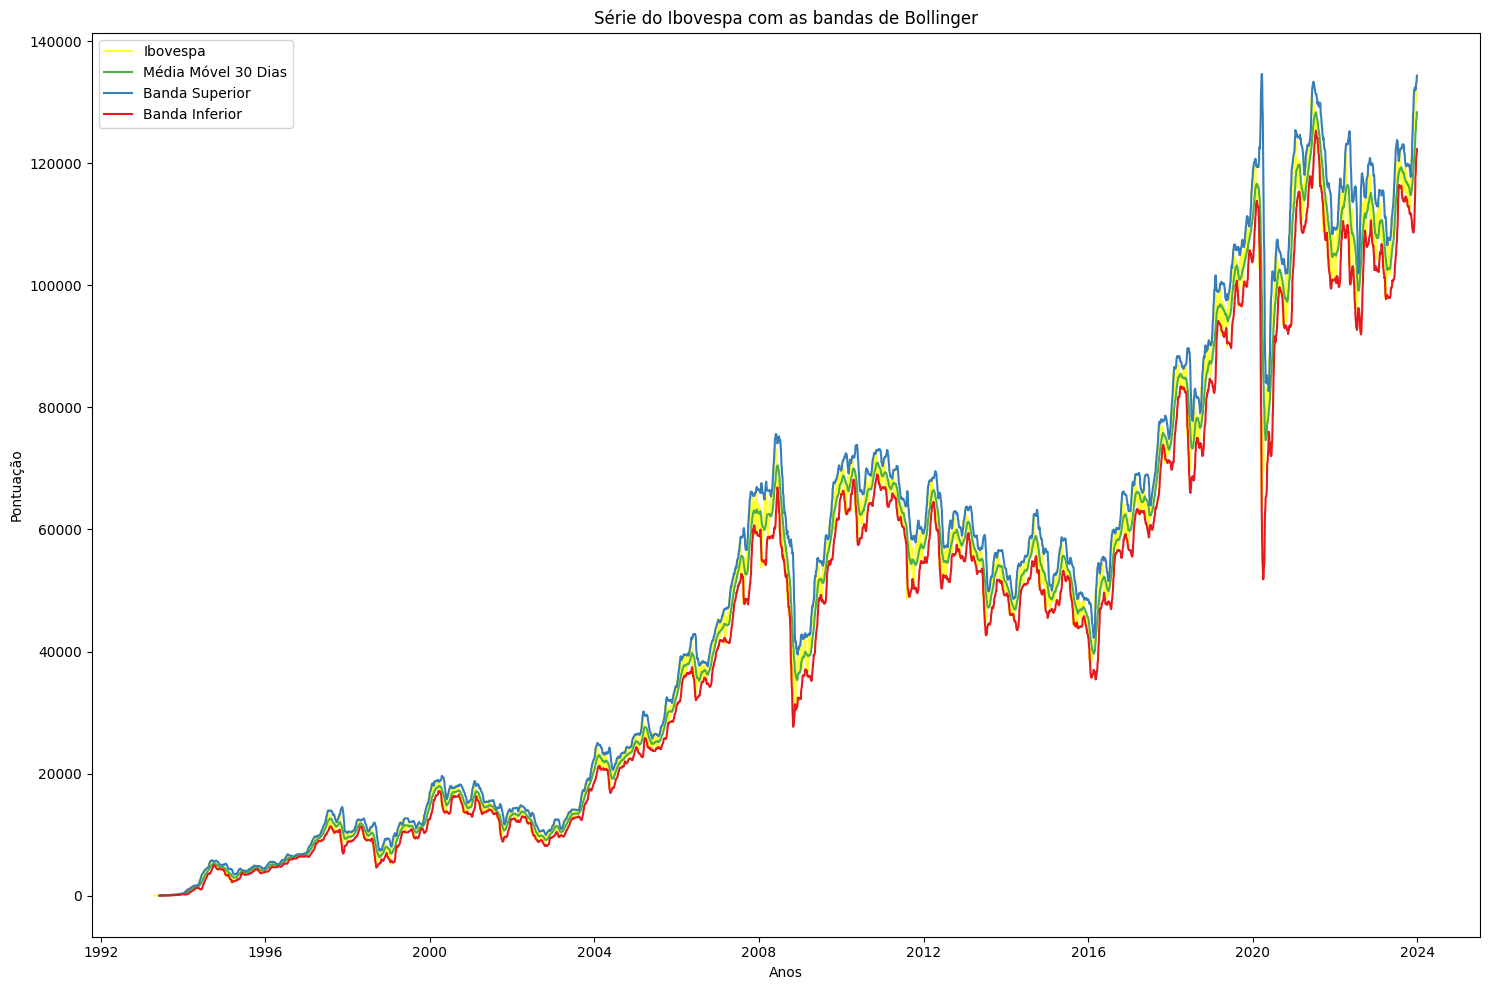

In [ ]:
# Calcular média móvel e desvio padrão
window = 30
df_ibov['MM30'] = df_ibov['y'].rolling(window=window).mean()
df_ibov['DesvioPadrao'] = df_ibov['y'].rolling(window=window).std()

# Calculando as Bollinger Bands
k = 2
df_ibov['Banda Superior'] = df_ibov['MM30'] + (df_ibov['DesvioPadrao'] * k)
df_ibov['Banda Inferior'] = df_ibov['MM30'] - (df_ibov['DesvioPadrao'] * k)

# Plotar usando Seaborn
plt.figure(figsize=(15, 10))

palette = sns.color_palette("Set1")

sns.lineplot(data=df_ibov, x='ds', y='y', label='Ibovespa', color=palette[5])
sns.lineplot(data=df_ibov, x='ds', y='MM30', label='Média Móvel 30 Dias', color=palette[2])
sns.lineplot(data=df_ibov, x='ds', y='Banda Superior', label='Banda Superior', color=palette[1])
sns.lineplot(data=df_ibov, x='ds', y='Banda Inferior', label='Banda Inferior', color=palette[0])

# Estilização do gráfico
plt.xlabel('Anos')
plt.ylabel('Pontuação')
#plt.xticks(df_ibov['ds'][::365], df_ibov['ds'][::365].dt.year, rotation=-45)
plt.title('Série do Ibovespa com as bandas de Bollinger')

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#pq o indice é importante
df_ibov.loc['2020-07-08']

y                   99770.000000
MM30                94380.766667
MM180               98511.455556
MM30_forward_30     95280.179544
DesvioPadrao         3253.615884
Banda Superior     100887.998435
Banda Inferior      87873.534898
Name: 2020-07-08 00:00:00, dtype: float64

___________________________________________________________

### ARIMA - Redução da Série Temporal - 1º ACF| PACF


Com o objetivo de simplificar a análise e facilitar os ajustes nos modelos diante da série de eventos caóticos que afetaram o fechamento diário do índice Bovespa, como as significativas quedas ocorridas durante a crise imobiliária dos EUA em 2008 e a pandemia em 2020, decidimos restringir a série temporal a um intervalo que vai de 04 de janeiro de 2021 a dezembro de 2023. Isso proporcionará uma base mais estável e recente para nossa análise.

ACF (Autocorrelation Function)
A Função de Autocorrelação, ou ACF, nos dá uma visão geral da autocorrelação em todos os atrasos. É como olhar para o lago de cima e ver todas as ondas que a pedra criou. O ACF nos mostra a correlação entre a série e sua versão defasada.

PACF (Partial Autocorrelation Function)
A Função de Autocorrelação Parcial, ou PACF, é um pouco mais específica. Ela nos mostra a autocorrelação em um atraso, controlando os atrasos anteriores. Usando nossa analogia do lago, é como focar em uma onda específica, ignorando todas as outras.

In [ ]:
#Determinando o range para trabalhar, depois de 2020 da pandemia
start_date_new = '2021-01-01'
end_date_new = '2023-12-31'

# Filtrar as datas desejadas
df_ibov2021 = df_ibov[(df_ibov.index >= start_date_new) & (df_ibov.index <= end_date_new)]

df_ibov2021.head()

,y,MM30,MM180,MM30_forward_30,DesvioPadrao,Banda Superior,Banda Inferior
ds,,,,,,,
2021-01-04,118558.0,113623.833333,97923.994444,115462.381889,4074.369535,121772.572404,105475.094263
2021-01-05,119223.0,114023.633333,98151.083333,115394.020078,4013.235426,122050.104185,105997.162481
2021-01-06,119851.0,114469.233333,98375.455556,118167.000000,3887.273530,122243.780393,106694.686274
2021-01-07,121956.0,114983.866667,98597.305556,118168.000000,3819.569417,122623.005501,107344.727832
2021-01-08,125077.0,115573.800000,98836.888889,118216.900000,3968.326794,123510.453588,107637.146412


In [ ]:
df_ibov2021['y'].tail()

ds
2023-12-21    132182.0
2023-12-22    132753.0
2023-12-26    133533.0
2023-12-27    134194.0
2023-12-28    134185.0
Name: y, dtype: float64

In [ ]:
# Cálculo da ACF e PACF para as colunas 'ds' e 'y' do DataFrame
lag_acf = acf(df_ibov2021['y'], nlags=40)  # Autocorrelation Function (ACF)
lag_pacf = pacf(df_ibov2021['y'], nlags=40, method='ols')  # Partial Autocorrelation Function (PACF)
conf_int = 1.96 / np.sqrt(len(df_ibov2021['y']))  # Intervalo de confiança

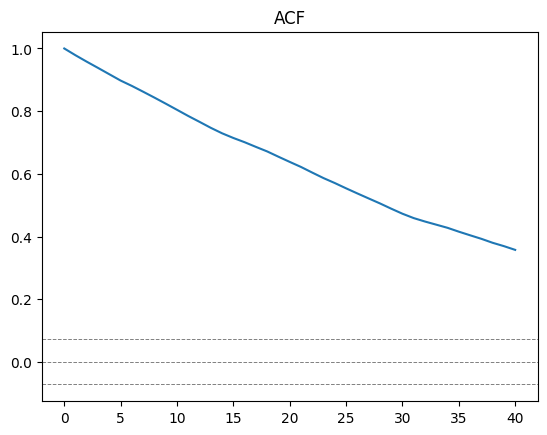

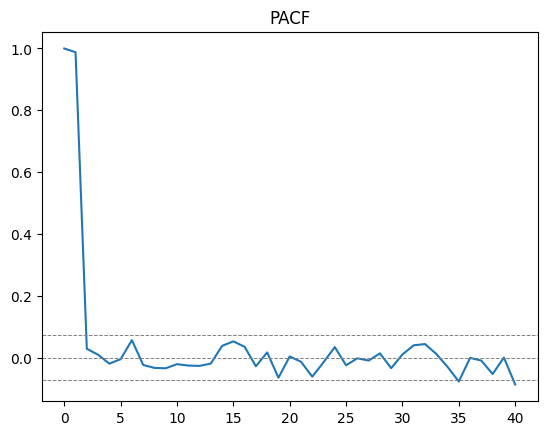

In [ ]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_ibov2021) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_ibov2021) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_ibov2021) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_ibov2021) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

##3.Modelagem

###Decomposição e Dickey-Fuller

In [ ]:
resultados = seasonal_decompose(df_ibov2021['y'], model='additive', period=12)

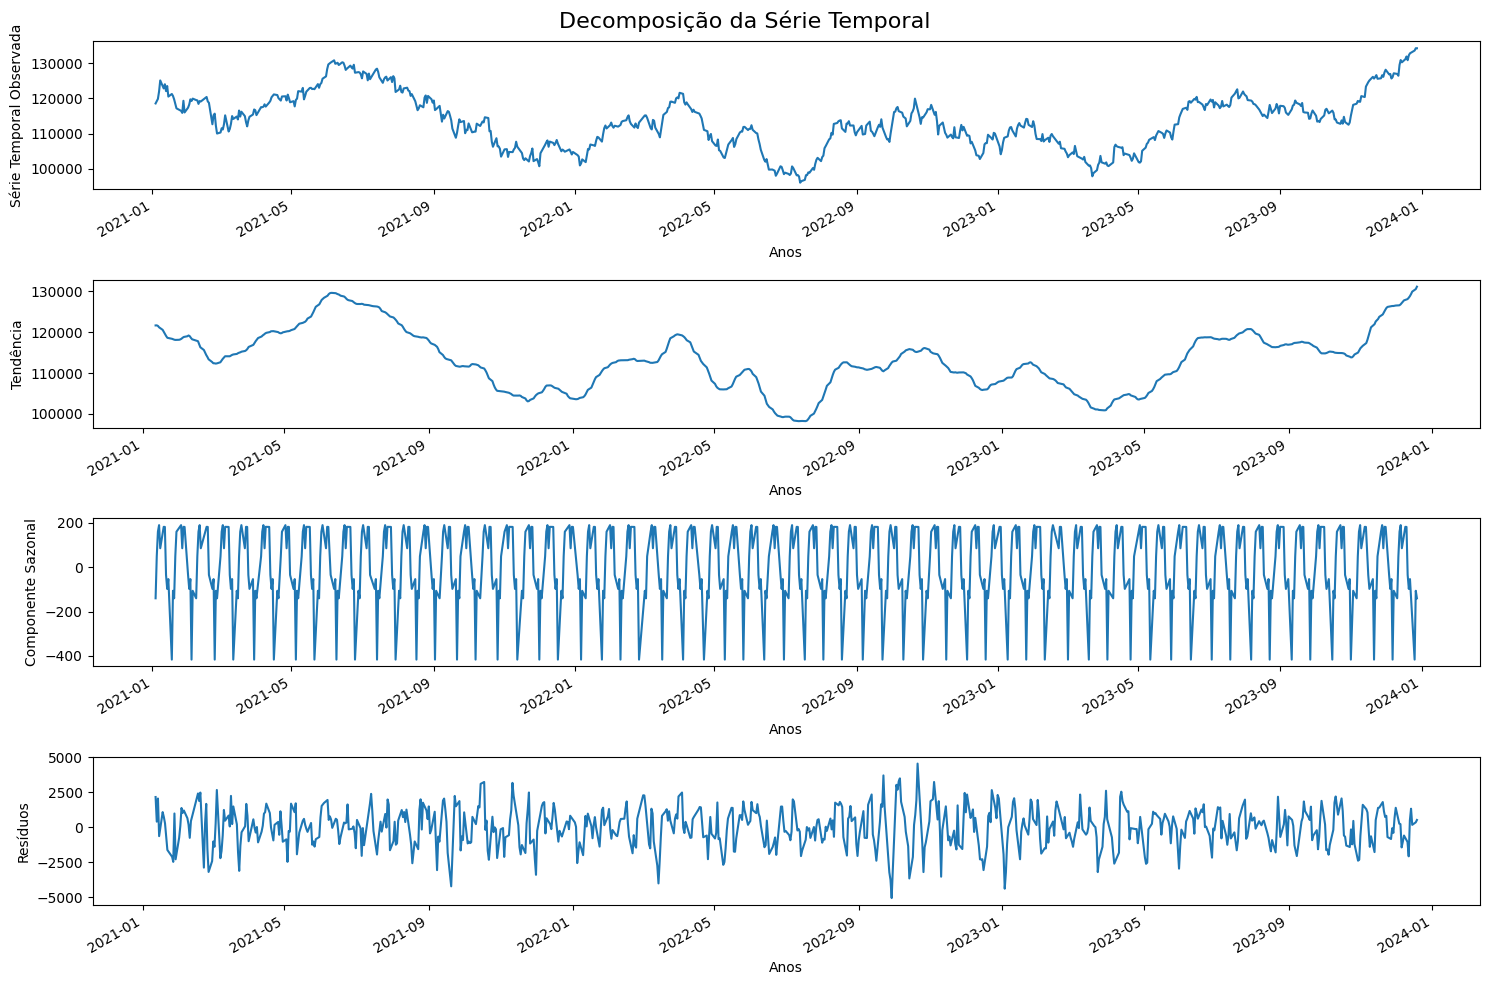

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1, label='Ibovespa')
ax1.set_ylabel('Série Temporal Observada')
ax1.set_xlabel('Anos')

resultados.trend.plot(ax=ax2)
ax2.set_ylabel('Tendência')
ax2.set_xlabel('Anos')

resultados.seasonal.plot(ax=ax3)
ax3.set_ylabel('Componente Sazonal')
ax3.set_xlabel('Anos')

resultados.resid.plot(ax=ax4)
ax4.set_ylabel('Resíduos')
ax4.set_xlabel('Anos')

plt.suptitle('Decomposição da Série Temporal', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#não vai plotar fundo branco
sns.set_style('darkgrid')

In [ ]:
X = df_ibov2021.y.values

In [ ]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste estatístico: -1.8177677809316526
P-Value: 0.3716768428097197
Valores críticos:
	1%: -3.4391698996357687
	5%: -2.8654325580580204
	10%: -2.568842816582842


- valor p alto (de acordo com a hipótese nula) (valor p no máximo pode ser 1)
- Os valores críticos em intervalos de confiança de 1%,5%,10% devem ser o mais próximo possível das Estatísticas de Teste.

Portanto, podemos dizer com segurança que nossa Série Temporal no momento **não** é estacionária.

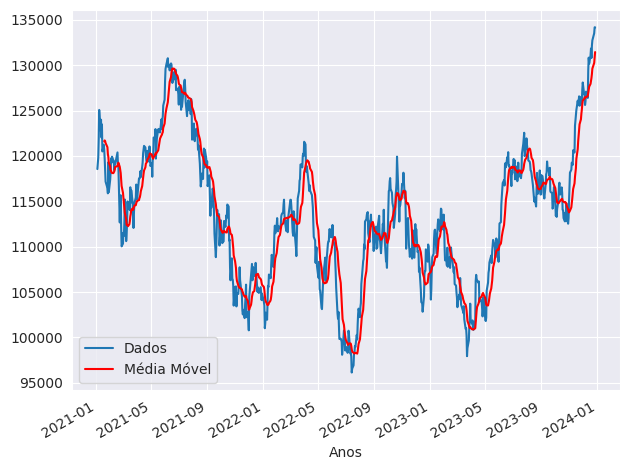

In [ ]:
#media movel
ma = df_ibov2021['y'].rolling(12).mean()

f, ax = plt.subplots()

#df_ibov2021['y'].plot(ax=ax, legend=False)
#ma.plot(ax=ax, legend=False, color="r")

df_ibov2021['y'].plot(ax=ax, legend=True, label='Dados')
ma.plot(ax=ax, color="r", legend=True, label='Média Móvel')
plt.xlabel('Anos')
plt.tight_layout()

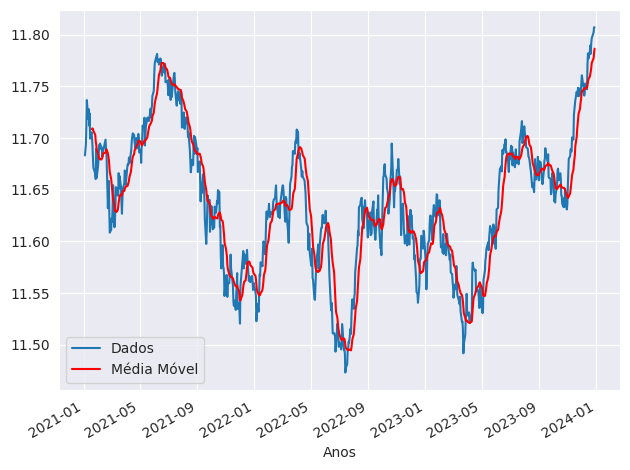

In [ ]:
#aplicar log (transformando escala)
df_log = np.log(df_ibov2021['y'])
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=True, label='Dados')
ma_log.plot(ax=ax, color="r", legend=True, label='Média Móvel')
plt.xlabel('Anos')
plt.tight_layout()

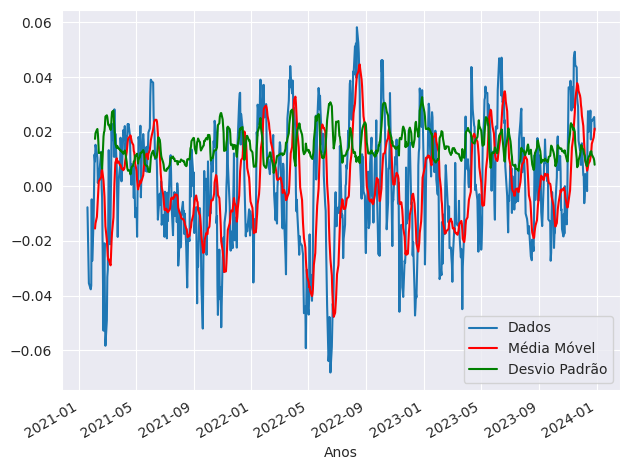

In [ ]:
#fez o drop na para que seja retirado valores nulos - o 12 é fazendo apenas dos 12 meses
df_ibov2021_s = (df_log - ma_log).dropna() #subtrai da média

ma_s = df_ibov2021_s.rolling(12).mean() #média móvel

std = df_ibov2021_s.rolling(12).std() #desvio padrao

f, ax = plt.subplots()
df_ibov2021_s.plot(ax=ax, legend=True, label='Dados')
ma_s.plot(ax=ax, color="r", legend=True, label='Média Móvel')
std.plot(ax=ax, color="g", legend=True, label='Desvio Padrão')
plt.xlabel('Anos')
plt.tight_layout()

---------------------------------------------------

* Teste ADF de novo

In [ ]:
X_s = df_ibov2021_s.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste estatístico: -7.396533473983272
P-Value: 7.751743499450267e-11
Valores críticos:
	1%: -3.439302726125018
	5%: -2.8654910924750547
	10%: -2.5688740002680124


p-value mto proximo de zero = quanto mais proximo de zero mais confinaça vc tem

Em termos decimais, 8.122917289387604e-11 é equivalente a 0.00000000008122917289387604, ou seja, é um número extremamente próximo de zero.

Serie = estacionaria

Em um teste ADF, a hipótese nula (H0) é que a série temporal não é estacionária. Para rejeitar essa hipótese nula e considerar que a série é estacionária, o valor p (P-Value) deve ser menor que um certo nível de significância, geralmente 0.05. No seu caso, o valor p é muito menor que 0.05 (é um valor extremamente baixo, próximo de zero), o que sugere fortemente rejeitar a hipótese nula.

Além disso, ao observar o valor do teste estatístico (-7.387991951713241), que é menor do que os valores críticos para os níveis de significância de 1%, 5%, e 10%, indica que podemos rejeitar a hipótese nula de não estacionariedade. Isso sugere que a sua série temporal é estacionária.

Portanto, com base nos resultados do teste ADF, é razoável concluir que a sua série temporal é estacionária.

---------------------------------------------

* Fazer diferenciação

Teste ADF
Teste estatístico: -9.989749622071283
P-Value: 2.0107788496876173e-17
Valores críticos:
	1%: -3.439516060164992
	5%: -2.8655850998755263
	10%: -2.5689240826597173


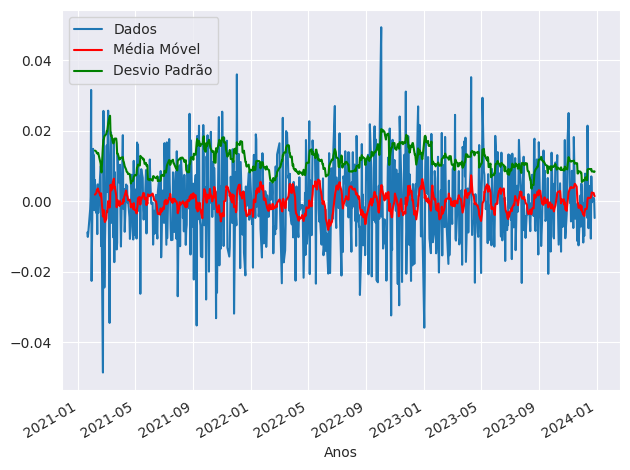

In [ ]:
#1 derivada
df_diff = df_ibov2021_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

#desvio padrão
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=True, label='Dados')
ma_diff.plot(ax=ax, color="r", legend=True, label='Média Móvel')
std_diff.plot(ax=ax, color="g", legend=True, label='Desvio Padrão')
plt.xlabel('Anos')
plt.tight_layout()

X_diff = df_diff.dropna().values#tem q dropar
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

p-value está cada vez mais proximo de zero

Ela agora está estacionaria.

----------------------------------------------------

###ARIMA - após diferenciação

ARIMA - (ar): autoregressivo, I: integrado, MA: Moving Averege

* (x, y, z) -> ACF, PACF
* ACF = AUTOCORRELAÇÃO - EM 1 VARIAVEL
* PACF = AUTOCORRELAÇÃO PARCIAL

In [ ]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

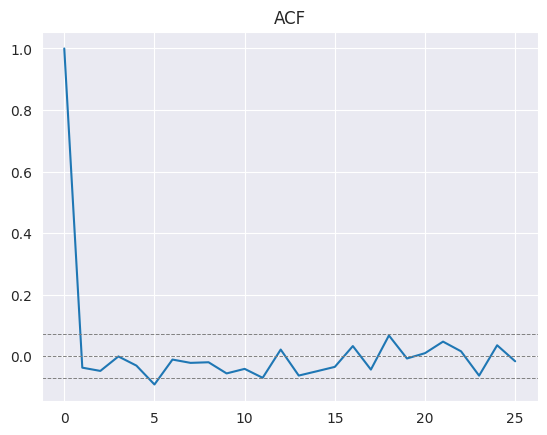

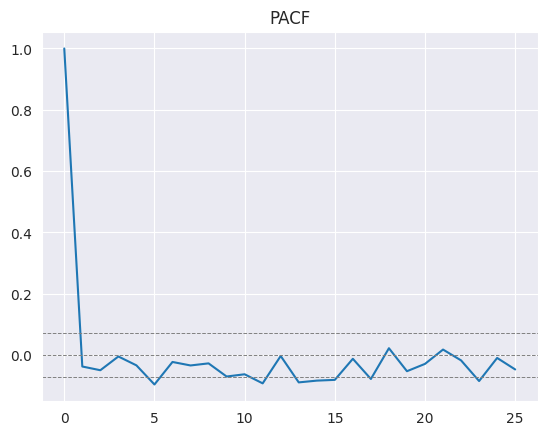

In [ ]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

NO ARIMA - FUNCIONARIA ASSIM:

* A(x,y, z)
* x= é onde o ponto pega no limite superior na primeira vez do ACF que seria o numero 18
* y = é onde o ponto passa o limite superir no PACF na primeira vez - que seria 0

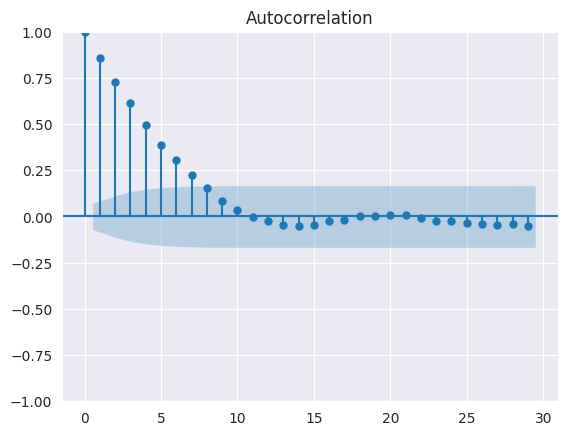

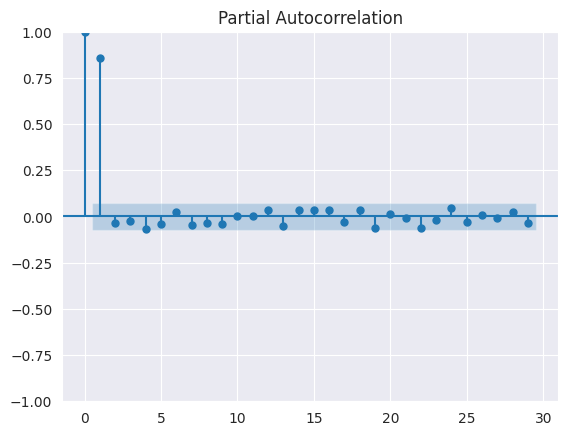

In [ ]:
plot_acf(df_ibov2021_s)
plot_pacf(df_ibov2021_s)

plt.show()

* o cone azul é a largura banda de confiança
* a correlação parcial, tem a negativa

Conclusão

Ao observar os gráficos de ACF e PACF, notamos que ambos representam consistentemente o intervalo de confiança em todos os lags. Isso sugere que, após a diferenciação, a série temporal não apresenta autocorrelações significativas em seus lags. Esse é um bom indicativo de que a diferenciação foi eficaz em remover padrões e tendências da série, tornando-a estacionária e, assim, mais adequada para modelagem ARIMA.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Plotting AR model


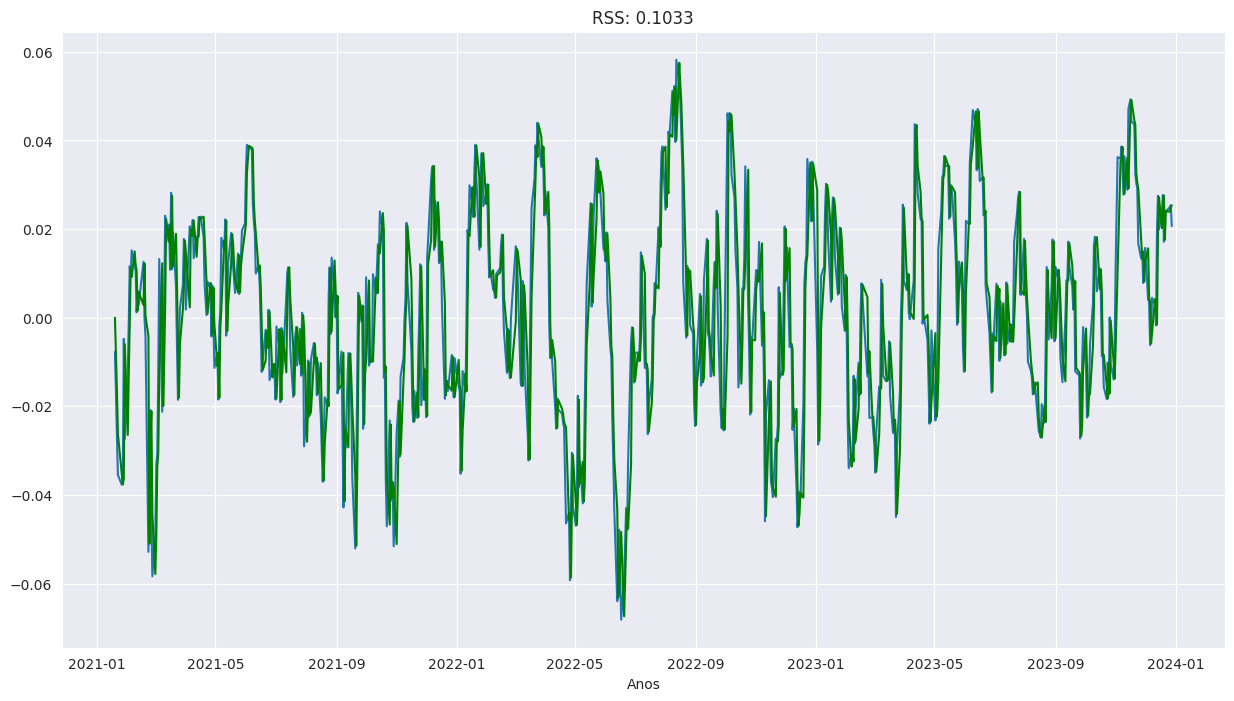

In [ ]:
#AR Model
model = ARIMA(df_ibov2021_s, order=(1,1,0))#(p,d,q) TEM Q ESCOLHER CONFORME GRAFICO E ONDE PEGA O PONTO.
plt.figure(figsize=(15, 8))
results_AR = model.fit()
plt.plot(df_ibov2021_s)
plt.plot(results_AR.fittedvalues, color='g')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_ibov2021_s)**2))
plt.xlabel('Anos')

print('Plotting AR model')

RSS significa "Residual Sum of Squares" (Soma dos Quadrados dos Resíduos, em português). Em contextos de modelagem estatística, como regressão linear, séries temporais (como no caso do modelo ARIMA) e em várias técnicas de ajuste de modelo, o RSS é uma medida que representa a quantidade de variação não explicada pelo modelo.

Em termos simples, o RSS é calculado como a soma dos quadrados das diferenças entre os valores reais e os valores previstos pelo modelo. Quanto menor o valor do RSS, melhor o modelo está em se ajustar aos dados.

--------------------------------

In [ ]:
# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = df_ibov2021_s.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = df_log.iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(df_ibov2021_s, predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 1126.06%


Um MAPE tão alto geralmente indica que as previsões do modelo estão muito distantes dos valores reais. RUIM

--------------------------

##4.Prophet

In [ ]:
df_ibov.head()

,y,MM30,MM180,MM30_forward_30,DesvioPadrao,Banda Superior,Banda Inferior
ds,,,,,,,
1993-04-27,24.500000,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-28,24.299999,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-29,23.700001,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-30,24.100000,NaN,NaN,NaN,NaN,NaN,NaN
1993-05-03,24.100000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ibov2021.head()

,y,MM30,MM180,MM30_forward_30,DesvioPadrao,Banda Superior,Banda Inferior
ds,,,,,,,
2021-01-04,118558.0,113623.833333,97923.994444,115462.381889,4074.369535,121772.572404,105475.094263
2021-01-05,119223.0,114023.633333,98151.083333,115394.020078,4013.235426,122050.104185,105997.162481
2021-01-06,119851.0,114469.233333,98375.455556,118167.000000,3887.273530,122243.780393,106694.686274
2021-01-07,121956.0,114983.866667,98597.305556,118168.000000,3819.569417,122623.005501,107344.727832
2021-01-08,125077.0,115573.800000,98836.888889,118216.900000,3968.326794,123510.453588,107637.146412


In [ ]:
ticker = "^BVSP"  # Substitua pelo ticker da ação desejada

# Definir o intervalo de datas desejado - format '%Y-%m-%d'"
start_date = '2021-01-01'
end_date = '2023-12-31'

# Obter os dados do Yahoo Finance para o ticker especificado no intervalo de datas
df = yf.download(ticker, start=start_date, end=end_date)

# Exibir as cotações de fechamento diárias
print(df['Close'])

[*********************100%%**********************]  1 of 1 completed
Date
2021-01-04    118558.0
2021-01-05    119223.0
2021-01-06    119851.0
2021-01-07    121956.0
2021-01-08    125077.0
                ...   
2023-12-21    132182.0
2023-12-22    132753.0
2023-12-26    133533.0
2023-12-27    134194.0
2023-12-28    134185.0
Name: Close, Length: 745, dtype: float64


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,119024.0,120354.0,118062.0,118558.0,118558.0,8741400
2021-01-05,118835.0,119790.0,116756.0,119223.0,119223.0,9257100
2021-01-06,119377.0,120924.0,118917.0,119851.0,119851.0,11638200
2021-01-07,119103.0,121983.0,119101.0,121956.0,121956.0,11774800
2021-01-08,122387.0,125324.0,122386.0,125077.0,125077.0,11085800


In [ ]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds','y']] = df[['Date','Close']]
df.head()

,Date,Close,ds,y
0,2021-01-04,118558.0,2021-01-04,118558.0
1,2021-01-05,119223.0,2021-01-05,119223.0
2,2021-01-06,119851.0,2021-01-06,119851.0
3,2021-01-07,121956.0,2021-01-07,121956.0
4,2021-01-08,125077.0,2021-01-08,125077.0


In [ ]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (596, 4)
testing data size : (149, 4)


In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=24, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpov44g5ht/p1q_22ds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpov44g5ht/uz6fff2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97525', 'data', 'file=/tmp/tmpov44g5ht/p1q_22ds.json', 'init=/tmp/tmpov44g5ht/uz6fff2w.json', 'output', 'file=/tmp/tmpov44g5ht/prophet_modelfoklhyi5/prophet_model-20240110000555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:05:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:05:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,118256.047008,114772.251280,121775.948362,118256.047008,118256.047008,-32.480936,-32.480936,-32.480936,4149.364364,...,109.854924,109.854924,109.854924,-4291.700224,-4291.700224,-4291.700224,0.0,0.0,0.0,118223.566072
1,2021-01-05,118152.352048,114767.904142,121883.613174,118152.352048,118152.352048,141.137116,141.137116,141.137116,4149.364364,...,180.990091,180.990091,180.990091,-4189.217339,-4189.217339,-4189.217339,0.0,0.0,0.0,118293.489164
2,2021-01-06,118048.657088,114676.231809,121713.721171,118048.657088,118048.657088,234.661953,234.661953,234.661953,4149.364364,...,164.009299,164.009299,164.009299,-4078.711710,-4078.711710,-4078.711710,0.0,0.0,0.0,118283.319041
3,2021-01-07,117944.962128,114579.071656,121856.904189,117944.962128,117944.962128,363.091747,363.091747,363.091747,4149.364364,...,173.162998,173.162998,173.162998,-3959.435616,-3959.435616,-3959.435616,0.0,0.0,0.0,118308.053875
4,2021-01-08,117841.267168,115089.576761,122002.712059,117841.267168,117841.267168,727.915578,727.915578,727.915578,4149.364364,...,409.322629,409.322629,409.322629,-3830.771415,-3830.771415,-3830.771415,0.0,0.0,0.0,118569.182746


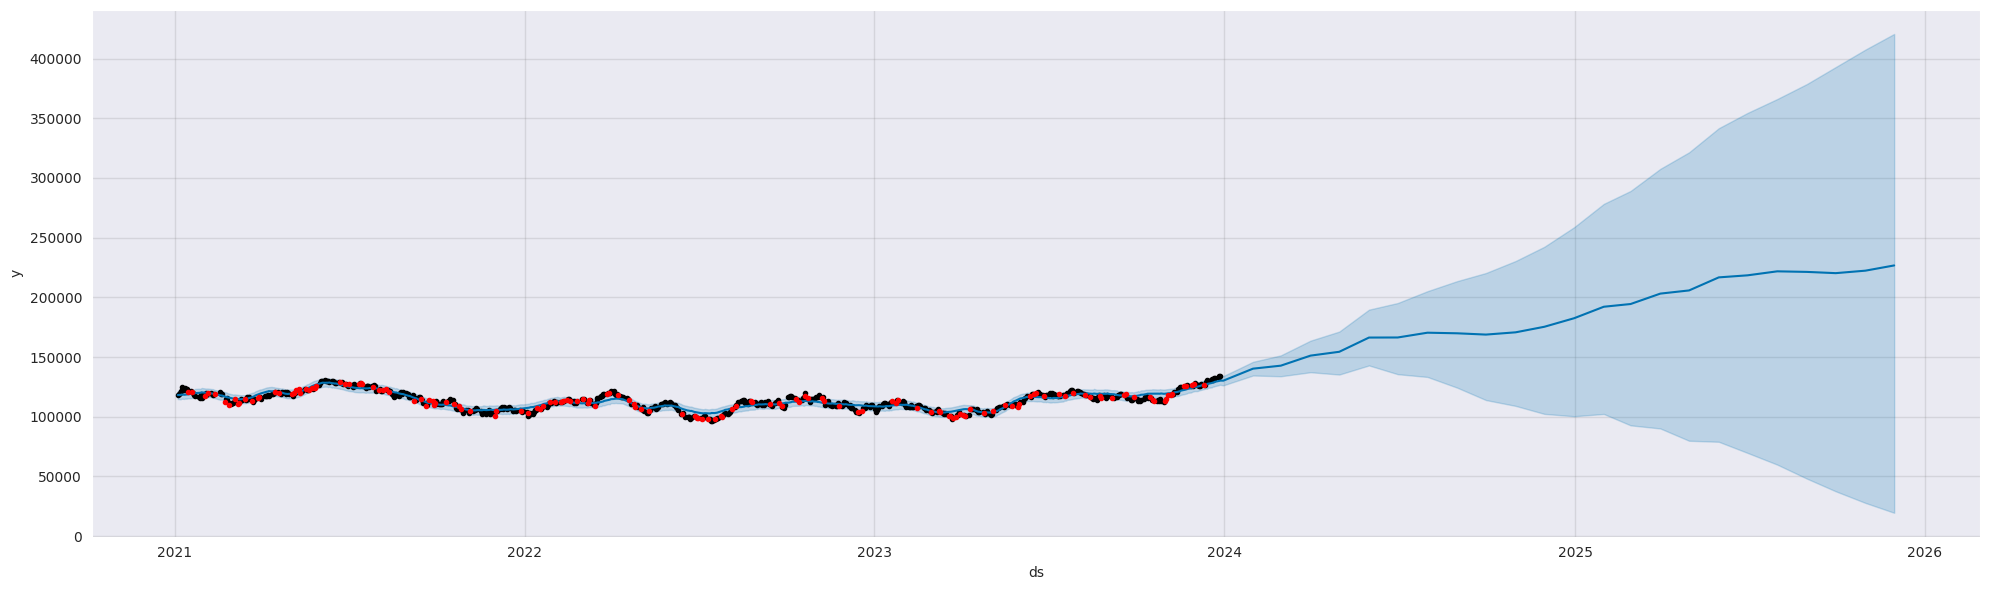

In [ ]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

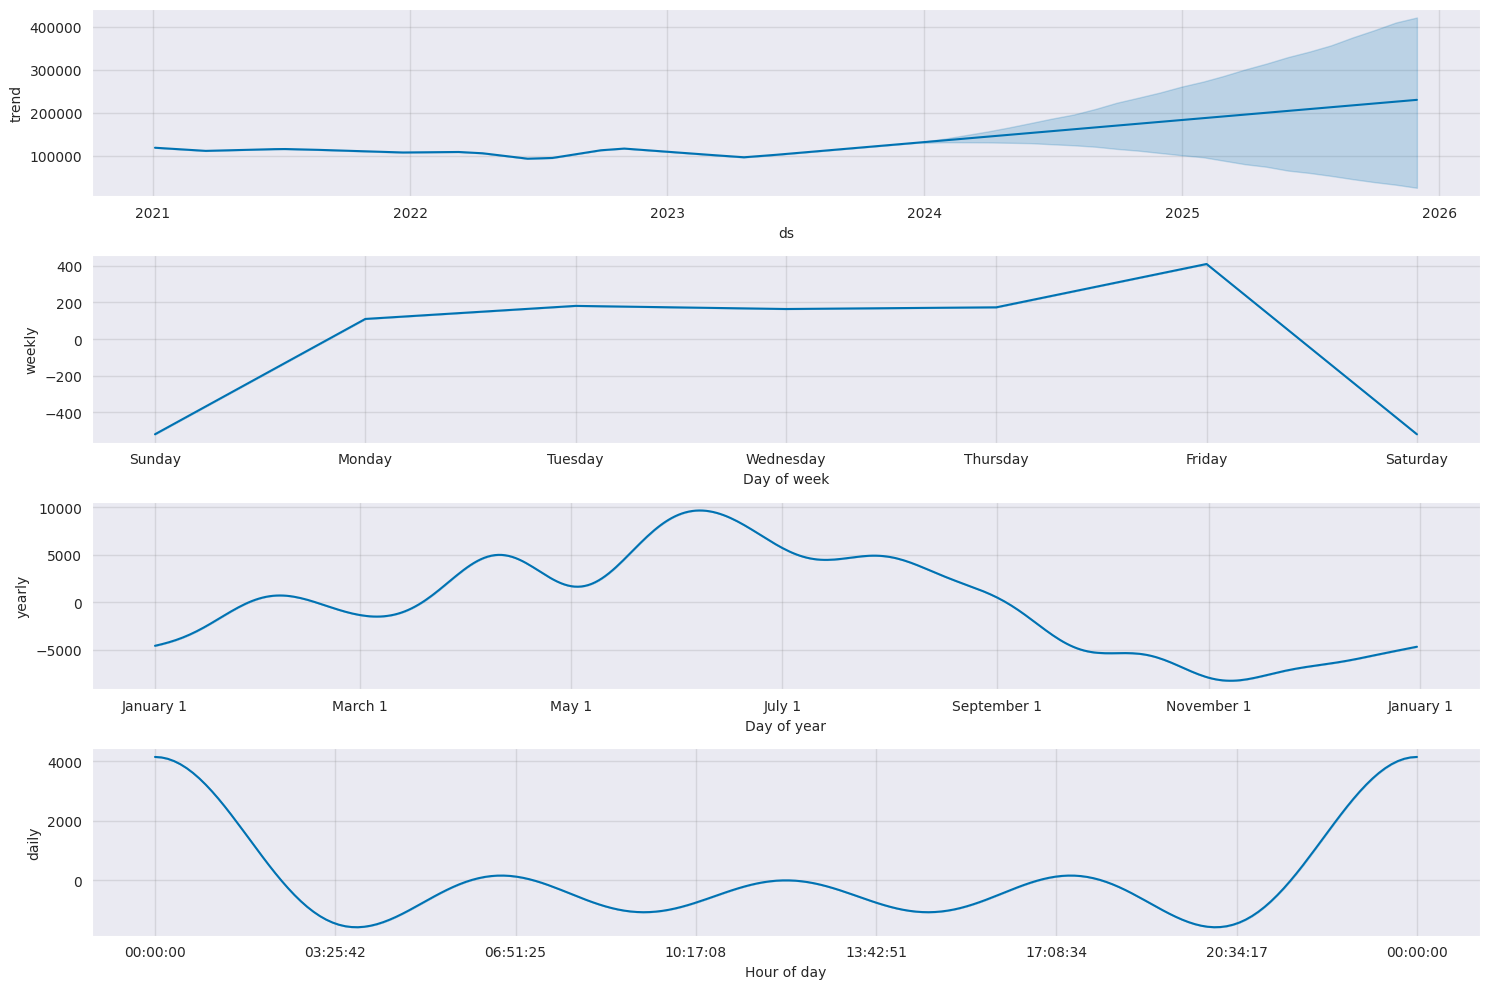

In [ ]:
modelo.plot_components(previsao, figsize=(15,10));

In [ ]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.97%


* MAPE: 1,97% = quando calculado desde 2021
* MAPE: 21.69% = quando calculado desde o começo a bolsa de 1993

###Cross validation

Cross-validation é uma técnica estatística usada para avaliar o desempenho de um modelo de aprendizado de máquina, estimando como o modelo se comportará com dados não vistos. É especialmente útil para verificar se um modelo treinado pode generalizar bem para novos dados, identificando problemas de overfitting (sobreajuste) ou underfitting (subajuste).

O procedimento básico de validação cruzada, conhecido como k-fold cross-validation, funciona assim:

Divisão dos dados: Os dados são divididos em k subconjuntos (ou "folds") de tamanhos aproximadamente iguais.

Treino e teste: O modelo é treinado k vezes. Em cada iteração, um dos k subconjuntos é usado como conjunto de teste (avaliação do modelo) e os k-1 subconjuntos restantes são usados como conjunto de treinamento.

Avaliação do desempenho: O desempenho do modelo é avaliado em cada iteração usando a métrica adequada (como erro médio, acurácia, F1-score, etc.). Ao final das k iterações, as métricas são geralmente combinadas para obter uma avaliação geral do modelo.

Principais benefícios da validação cruzada:

Melhor estimativa do desempenho do modelo: Permite uma avaliação mais robusta do modelo, pois usa múltiplos subconjuntos de dados para treino e teste.
Redução do viés de seleção do conjunto de teste: Evita que o modelo se ajuste excessivamente a um único conjunto de teste.
Utilização eficiente dos dados: Todos os dados são usados para treinamento e validação, maximizando o uso dos dados disponíveis.
O k-fold cross-validation é um dos métodos mais comuns, mas existem variações, como a validação cruzada leave-one-out (LOOCV), em que cada amostra é usada como conjunto de teste uma vez.

Em resumo, a validação cruzada é uma técnica fundamental para avaliar o desempenho de modelos de machine learning e garantir que eles generalizem bem para novos conjuntos de dados não vistos.

Explicação:
https://facebook.github.io/prophet/docs/diagnostics.html

In [ ]:
df_cv = cross_validation(modelo, initial='365 days', period='180 days', horizon = '180 days')

INFO:prophet:Making 4 forecasts with cutoffs between 2022-01-07 00:00:00 and 2023-07-01 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpov44g5ht/zo9onn7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpov44g5ht/58cif4rq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46521', 'data', 'file=/tmp/tmpov44g5ht/zo9onn7z.json', 'init=/tmp/tmpov44g5ht/58cif4rq.json', 'output', 'file=/tmp/tmpov44g5ht/prophet_model7dfvr5q6/prophet_model-20240110000558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpov44g5ht/gb20w16i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpov44g5ht/evnrtmec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-10,101214.892526,99285.202800,103391.185611,101945.0,2022-01-07
1,2022-01-11,100589.873416,98521.702396,102703.106284,103779.0,2022-01-07
2,2022-01-12,100760.324007,98723.249308,102754.907784,105686.0,2022-01-07
3,2022-01-13,100295.653598,98382.057085,102217.539500,105530.0,2022-01-07
4,2022-01-18,99133.653330,97037.571253,101136.995454,106522.0,2022-01-07


In [ ]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,16 days,2.208792e+07,4699.779193,4139.113320,0.038609,0.033569,0.039568,0.230769
1,17 days,2.331897e+07,4828.972455,4220.993533,0.039192,0.033236,0.040235,0.230769
2,18 days,2.583641e+07,5082.952898,4376.512576,0.040573,0.033236,0.041738,0.213675
3,19 days,2.939616e+07,5421.822869,4616.658309,0.042679,0.033236,0.044000,0.213675
4,20 days,2.978916e+07,5457.944545,4688.965674,0.043264,0.033236,0.044599,0.196581
...,...,...,...,...,...,...,...,...
156,176 days,2.422537e+09,49219.273580,34522.178100,0.314182,0.126640,0.485676,0.478632
157,177 days,2.365371e+09,48635.080762,33891.781251,0.308120,0.104675,0.475248,0.495726
158,178 days,2.147918e+09,46345.633223,31560.515865,0.285194,0.104675,0.435288,0.512821
159,179 days,1.991127e+09,44622.049648,30016.376545,0.268709,0.104675,0.406361,0.564103


###Algoritimo LSTM (Long Short-Term Memory)


LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente (RNN) especializada em lidar com sequências de dados e é conhecida por lidar de forma eficaz com problemas de dependência de longo prazo. Essa arquitetura foi projetada para superar o problema do desaparecimento do gradiente que é comum em redes neurais recorrentes tradicionais ao lidar com sequências de dados muito longas.

As LSTMs foram introduzidas para resolver a limitação das RNNs padrão em reter informações de longo prazo e lembrar sequências anteriores de maneira eficiente. Elas conseguem fazer isso através de unidades de memória especiais chamadas células de memória, que são estruturas fundamentais dentro das LSTMs.

In [ ]:
df_ibov2021.tail()

,y,MM30,MM180,MM30_forward_30,DesvioPadrao,Banda Superior,Banda Inferior
ds,,,,,,,
2023-12-21,132182.0,126625.933333,116169.394444,126643.291304,3178.980155,132983.893642,120267.973024
2023-12-22,132753.0,127083.966667,116339.816667,126706.620434,3030.572149,133145.110965,121022.822369
2023-12-26,133533.0,127513.866667,116511.394444,130249.700000,2998.942316,133511.751299,121515.982034
2023-12-27,134194.0,127974.466667,116692.255556,130583.070000,2925.078634,133824.623935,122124.309398
2023-12-28,134185.0,128336.366667,116877.655556,131001.077000,3001.025049,134338.416764,122334.316569


In [ ]:
df_ibov2021.reset_index(inplace=True)
df_ibov2021.drop(columns=['MM30', 'MM180', 'MM30_forward_30', 'DesvioPadrao', 'Banda Superior', 'Banda Inferior'], inplace=True)
df_ibov2021.rename(columns={'ds': 'Date', 'y': 'Close'}, inplace=True)
df = df_ibov2021
df.tail()

<ipython-input-63-4a48e2e90617>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibov2021.drop(columns=['MM30', 'MM180', 'MM30_forward_30', 'DesvioPadrao', 'Banda Superior', 'Banda Inferior'], inplace=True)
<ipython-input-63-4a48e2e90617>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibov2021.rename(columns={'ds': 'Date', 'y': 'Close'}, inplace=True)


,Date,Close
740,2023-12-21,132182.0
741,2023-12-22,132753.0
742,2023-12-26,133533.0
743,2023-12-27,134194.0
744,2023-12-28,134185.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    745 non-null    datetime64[ns]
 1   Close   745 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.8 KB


In [ ]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

Normalizando os dados

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

596
149


In [ ]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
np.random.seed(43)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
30/30 [==============================] - 2s 8ms/step - loss: 0.0992 - mean_squared_error: 0.0992
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 7/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 10/20
30/30 [=========

In [ ]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

139/139 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Erro Quadrático Médio 0.0020658730063587427


In [ ]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

139/139 [==============================] - 1s 3ms/step
MAPE: 1.9674


In [ ]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.04545187571881652


O RMSE fornece uma métrica de erro na mesma unidade que a variável alvo (nesse caso, o preço de fechamento). Portanto significa que, em média, as previsões do modelo estão desviando em torno de 0.02 unidades da variável de destino. Quanto menor o RMSE, melhor é o desempenho do modelo em termos de previsões de regressão. Esse modelo ficou top né?

In [ ]:
import plotly.graph_objs as go

In [ ]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

139/139 [==============================] - 0s 3ms/step


------------------------------

###Validando com suavização da série temporal

In [ ]:
df.tail()

,Date,Close
740,2023-12-21,132182.0
741,2023-12-22,132753.0
742,2023-12-26,133533.0
743,2023-12-27,134194.0
744,2023-12-28,134185.0


<ipython-input-76-8c04117c3d05>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



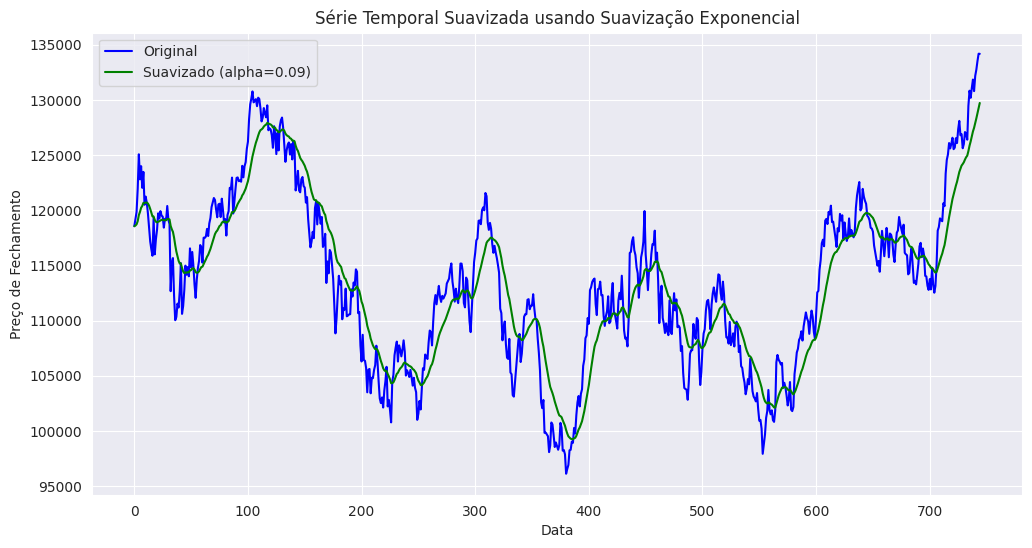

In [ ]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='g')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [ ]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.7478506904036826
p-value: 0.40664211217870133
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -1.7478506904036826
Valor-p: 0.40664211217870133
Valores Críticos:
   1%: -3.439181811684251
   5%: -2.865437807603377
   10%: -2.5688456132154935


In [ ]:
df.drop(columns=['Close'], inplace=True)
df.head()

<ipython-input-78-b402d19d4920>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Smoothed_Close
0,2021-01-04,118558.000000
1,2021-01-05,118617.850000
2,2021-01-06,118728.833500
3,2021-01-07,119019.278485
4,2021-01-08,119564.473421


In [ ]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
close_data

array([[0.63359675],
       [0.63555975],
       [0.63919987],
       [0.64872609],
       [0.66660778],
       [0.67617934],
       [0.68840516],
       [0.69375086],
       [0.70286912],
       [0.70237307],
       [0.70410605],
       [0.70400345],
       [0.70106151],
       [0.69465022],
       [0.6850641 ],
       [0.67425079],
       [0.66269269],
       [0.66230568],
       [0.65219162],
       [0.64699648],
       [0.64483409],
       [0.64726758],
       [0.64811238],
       [0.6508412 ],
       [0.65211711],
       [0.65302136],
       [0.65089531],
       [0.65133686],
       [0.6513874 ],
       [0.65519705],
       [0.65497102],
       [0.65360819],
       [0.63442057],
       [0.6245137 ],
       [0.61680023],
       [0.59970914],
       [0.57760012],
       [0.55836648],
       [0.54442088],
       [0.53067952],
       [0.52262041],
       [0.52270176],
       [0.50922664],
       [0.49908668],
       [0.4941248 ],
       [0.49612724],
       [0.49551711],
       [0.497

In [ ]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

596
149


In [ ]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina
look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
np.random.seed(43)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
30/30 [==============================] - 2s 9ms/step - loss: 0.0911 - mean_squared_error: 0.0911
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 3/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 4/100
30/30 [==============================] - 0s 6ms/step - loss: 9.0198e-04 - mean_squared_error: 9.0198e-04
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 8.4219e-04 - mean_squared_error: 8.4219e-04
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 8.7607e-04 - mean_squared_error: 8.7607e-04
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 9.5606e-04 - mean_squared_error: 9.5606e-04
Epoch 9/100
30/30 [==============================] - 0s 5ms/step - loss: 8.0787e-04 - mean_squar

In [ ]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")

144/144 [==============================] - 1s 2ms/step
MAPE: 0.76%


In [ ]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

144/144 [==============================] - 1s 3ms/step - loss: 1.9009e-04 - mean_squared_error: 1.9009e-04
Erro Quadrático Médio: 0.00019008708477485925


In [ ]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])
print("RMSE:", rmse_value)

RMSE: 0.013787207287005561


In [ ]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

fig.update_layout(
    autosize=False,
    width=1200,  # Largura em pixels
    height=800,  # Altura em pixels
)

fig.show()

144/144 [==============================] - 0s 2ms/step


##5.Forecasting

In [ ]:
close_data = close_data.reshape((-1))
# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 21ms/step


In [ ]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

###Organizando os dados em um dataframe

In [ ]:
df = pd.DataFrame(df)
df_past = df[['Date','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Date'] = pd.to_datetime(df_past['Date'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

<ipython-input-90-129f8e43c812>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Actual,Forecast
0,2021-01-04,118558.0000,NaN
1,2021-01-05,118617.8500,NaN
2,2021-01-06,118728.8335,NaN


In [ ]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [ ]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Date,Actual,Forecast
0,2023-12-28,NaN,129729.269998
1,2023-12-29,NaN,129832.608163
2,2023-12-30,NaN,130100.676055
3,2023-12-31,NaN,130295.550927
4,2024-01-01,NaN,130528.287140


In [ ]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Date')
results.head()

,Actual,Forecast
Date,,
2021-01-04,118558.000000,NaN
2021-01-05,118617.850000,NaN
2021-01-06,118728.833500,NaN
2021-01-07,119019.278485,NaN
2021-01-08,119564.473421,NaN


In [ ]:
results.tail(27)

,Actual,Forecast
Date,,
2024-01-01,NaN,130528.287140
2024-01-02,NaN,130749.065610
2024-01-03,NaN,130988.329516
2024-01-04,NaN,131229.483399
2024-01-05,NaN,131482.798562
2024-01-06,NaN,131743.731788
2024-01-07,NaN,132015.848594
2024-01-08,NaN,132298.211260
2024-01-09,NaN,132592.422632


In [ ]:
results2023 =  results.loc['2023-06-01':]

In [ ]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast',
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'